# Lab 03.1 — Datos Sintéticos con Synthea

**BE3006 · Análisis de Datos Biomédicos · Ciclo 1, 2026**

---

En **Lab 1** construiste un EHR relacional.  
En **Lab 2** normalizaste su semántica con ICD-10 y LOINC.  
En **Lab 3** convertiste esos datos a FHIR y ensamblaste Bundles de intercambio.

Ahora la pregunta natural:

> ¿Cómo se generan miles de registros clínicos realistas — con terminologías correctas, trayectorias de enfermedad coherentes y distribuciones epidemiológicas reales — para investigación, pruebas y entrenamiento de modelos?

La respuesta: **Synthea**, un simulador de poblaciones de pacientes sintéticos open-source.

---

```
┌────────────────────┐     ┌──────────────────────┐     ┌─────────────────────┐
│  Módulos de        │     │  Motor Synthea        │     │  Salida por         │
│  enfermedad        │────▶│  (simulación          │────▶│  paciente:          │
│  (JSON / máquinas  │     │   epidemiológica      │     │  CSV + FHIR R4      │
│   de estado)       │     │   probabilística)     │     │  Bundle             │
└────────────────────┘     └──────────────────────┘     └─────────────────────┘
```

---

**Objetivos:**

1. Entender qué son los datos sintéticos y por qué importan en salud digital
2. Explorar la estructura de salida de Synthea: archivos CSV y Bundles FHIR R4
3. Analizar una población sintética: demografía y epidemiología básica
4. Comparar un Bundle FHIR generado por Synthea con el que construiste en Lab 3
5. Reflexionar sobre los usos y limitaciones de datos sintéticos en biomedicina


---

## Parte 0 — Setup

Asegúrate de que Docker esté corriendo: `docker compose up -d`  
Luego abre Jupyter en `http://localhost:8888` y navega a `work/notebooks/`.


In [76]:
import json
import warnings
from datetime import date
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ─── Paths ────────────────────────────────────────────────────────────────────
DATA_DIR = Path('../data')
FHIR_DIR = Path('../fhir')

# ─── Display settings ─────────────────────────────────────────────────────────
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 80)
sns.set_theme(style='whitegrid', palette='muted')
warnings.filterwarnings('ignore')

# ─── Verificar archivos de datos ──────────────────────────────────────────────
csv_files = ['patients.csv', 'conditions.csv', 'encounters.csv',
             'medications.csv', 'observations.csv']
missing_csv = [f for f in csv_files if not (DATA_DIR / f).exists()]
fhir_files  = sorted(FHIR_DIR.glob('*.json'))

if missing_csv:
    print('⚠️  Faltan archivos CSV en data/:')
    for f in missing_csv:
        print(f'   • {f}')
    print()
    print('Para generarlos, ejecuta desde el directorio de Synthea:')
    print('  ./run_synthea -s 42 -p 100 \\')
    print('    --exporter.csv.export=true \\')
    print('    --exporter.fhir.export=true \\')
    print('    Massachusetts')
    print()
    print('Luego copia los CSV de synthea/output/csv/ → labs/lab-3.1-synthetic-data/data/')
    print('  y los JSON de synthea/output/fhir/ → labs/lab-3.1-synthetic-data/fhir/')
else:
    print('✓ Archivos CSV encontrados')
    if fhir_files:
        print(f'✓ {len(fhir_files)} archivos FHIR encontrados')
    else:
        print('⚠️  No hay archivos FHIR en fhir/ (Parte 5 los requiere)')
    print('\nSetup completo ✓')

✓ Archivos CSV encontrados
✓ 5 archivos FHIR encontrados

Setup completo ✓


---

## Parte 1 — ¿Qué es Synthea y por qué importan los datos sintéticos?

### El problema: privacidad vs. acceso a datos

Los datos clínicos reales son invaluables para investigación, pero:

- **Están protegidos por ley** (HIPAA en EE.UU., GDPR en Europa, legislaciones locales).
- **Compartirlos requiere consentimiento** del paciente y procesos de anonimización complejos.
- **La anonimización nunca es perfecta**: con suficiente contexto, un paciente puede re-identificarse.

Esto genera un dilema: los modelos de IA, los sistemas de EHR y los protocolos de investigación necesitan datos para desarrollarse y probarse, pero los datos reales son difíciles de obtener.

### La solución: datos sintéticos

Los datos sintéticos son datos **generados artificialmente** que:
- No corresponden a ningún individuo real
- Preservan las **distribuciones estadísticas** de la población real
- Incluyen **terminologías clínicas** correctas (SNOMED-CT, LOINC, RxNorm)
- Pueden generarse en la cantidad y con las características que se necesiten

### Usos principales en biomedicina:

| Uso | Ejemplo |
|-----|--------|
| Pruebas de sistemas | Probar un EHR nuevo sin datos reales |
| Entrenamiento de modelos IA | Entrenar un clasificador de diagnósticos |
| Investigación epidemiológica | Estudiar prevalencias sin acceder a datos hospitalarios |
| Educación | Laboratorios como este |
| Benchmarks | Comparar algoritmos de análisis clínico |


### ¿Cómo funciona Synthea?

Synthea modela la vida completa de un paciente usando **máquinas de estado probabilísticas**.
Cada enfermedad tiene su propio módulo (un archivo JSON) con:

- Estados (`Initial`, `Onset`, `Diagnosed`, `Treated`, `Death`, etc.)
- Transiciones basadas en probabilidades epidemiológicas reales
- Códigos terminológicos correctos (SNOMED-CT para condiciones, LOINC para labs, RxNorm para medicamentos)

```
  Initial
    │
    ▼  (probabilidad basada en edad, sexo, etnicidad)
  Assign_Hypertension_Probability
    │
    ├──[no HTN]──▶  Terminal
    │
    └──[HTN]──▶  Onset_Hypertension
                    │
                    ▼
                 Diagnose_Hypertension  ←── SNOMED: 59621000
                    │
                    ▼
                 Hypertension_Followup_Encounter
                    │
                    ├──[no control]──▶  Add_Medication  ←── RxNorm
                    │
                    └──[controlled]──▶  Terminal
```

Synthea tiene módulos para más de 60 enfermedades: diabetes, EPOC, insuficiencia cardiaca, cáncer de mama, opioides, COVID-19, y más.


### Los datos de este lab

Los archivos en `data/` y `fhir/` fueron generados con el siguiente comando:

```bash
# Desde el directorio de Synthea
./run_synthea -s 42 -p 100 \
  --exporter.csv.export=true \
  --exporter.fhir.export=true \
  Massachusetts
```

Parámetros:
- `-s 42` → semilla aleatoria (reproducibilidad: con la misma semilla obtienes los mismos pacientes)
- `-p 100` → 100 pacientes
- `--exporter.csv.export=true` → genera CSVs relacionales
- `--exporter.fhir.export=true` → genera un Bundle FHIR R4 por paciente
- `Massachusetts` → estado de EE.UU. (define demografía de base)

> 💡 Con la misma semilla (`-s 42`) y el mismo número de pacientes (`-p 100`), Synthea siempre genera exactamente los mismos datos. Esto hace el análisis **reproducible**.


#### Ejercicio 1.1 — Reflexión sobre datos sintéticos

Basándote en la descripción de Synthea y sus usos, responde:

**a)** ¿Por qué es importante que los datos sintéticos usen terminologías clínicas reales (SNOMED-CT, LOINC, RxNorm) en lugar de códigos inventados?

**b)** ¿Cuál es una limitación fundamental de los datos sintéticos que los hace inadecuados para ciertos tipos de investigación clínica?

**c)** ¿Qué ventaja tiene generar datos con una semilla fija (`-s 42`) en un contexto de investigación?


**Respuestas:**

**a)** Las terminologías reales (SNOMED-CT, LOINC, RxNorm) son estándares adoptados por sistemas EHR, APIs FHIR y pipelines clínicos en producción. Si los datos sintéticos usaran códigos inventados, no podrían usarse para probar esos sistemas ni para entrenar modelos que luego deban procesar datos reales. Además, las terminologías reales incluyen jerarquías y relaciones semánticas (ej. "diabetes tipo 2" es-un subconcepto de "diabetes mellitus") que los modelos pueden aprovechar; con códigos inventados se perderían esas relaciones.

**b)** Los datos sintéticos solo pueden reproducir los patrones que fueron explícitamente modelados. No capturan correlaciones emergentes, fenómenos raros o sesgos sistémicos del sistema de salud real (por ejemplo, qué condiciones no se diagnostican por falta de acceso). Son inadecuados para investigaciones que dependen de variabilidad inter-individual real, efectos de contexto socioeconómico no modelados, o prevalencias de enfermedades muy específicas de una población concreta.

**c)** Una semilla fija garantiza reproducibilidad: cualquier investigador que ejecute el mismo comando obtiene exactamente los mismos pacientes. Esto permite comparar algoritmos sobre el mismo dataset sin variabilidad aleatoria, replicar experimentos de forma independiente y facilita la revisión por pares. En este lab también garantiza que todos los estudiantes trabajen con los mismos datos, independientemente de cuándo ejecuten Synthea.

---

## Parte 2 — Estructura de datos CSV de Synthea

Synthea puede exportar datos en formato CSV relacional, con una tabla por tipo de registro clínico.  
Esta estructura debería resultarte familiar: es muy similar al EHR que construiste en Lab 1.


In [77]:
# Cargar todos los archivos CSV de Synthea
patients     = pd.read_csv(DATA_DIR / 'patients.csv',
                           parse_dates=['BIRTHDATE', 'DEATHDATE'])
conditions   = pd.read_csv(DATA_DIR / 'conditions.csv',
                           parse_dates=['START', 'STOP'])
encounters   = pd.read_csv(DATA_DIR / 'encounters.csv',
                           parse_dates=['START', 'STOP'])
medications  = pd.read_csv(DATA_DIR / 'medications.csv',
                           parse_dates=['START', 'STOP'])
observations = pd.read_csv(DATA_DIR / 'observations.csv',
                           parse_dates=['DATE'])

print('Registros cargados:')
print(f'  patients:     {len(patients):>6,}')
print(f'  conditions:   {len(conditions):>6,}')
print(f'  encounters:   {len(encounters):>6,}')
print(f'  medications:  {len(medications):>6,}')
print(f'  observations: {len(observations):>6,}')


Registros cargados:
  patients:        108
  conditions:    3,443
  encounters:    5,757
  medications:   4,183
  observations: 70,742


### 2.1 `patients.csv` — Demografía

Cada fila representa un paciente único. Las columnas clave son:

| Columna | Descripción |
|---------|-------------|
| `Id` | UUID único del paciente (actúa como `subject_id` en Lab 1) |
| `BIRTHDATE` / `DEATHDATE` | Fechas de nacimiento y fallecimiento |
| `GENDER` | M / F |
| `RACE` / `ETHNICITY` | Clasificación demográfica |
| `CITY`, `STATE` | Ubicación geográfica |
| `HEALTHCARE_EXPENSES` | Costo total de atención médica en vida |


In [ ]:
display(patients[['Id', 'BIRTHDATE', 'DEATHDATE', 'GENDER', 'RACE',
                  'ETHNICITY', 'CITY', 'HEALTHCARE_EXPENSES']].head(5))


### 2.2 `conditions.csv` — Diagnósticos

Cada fila representa una condición clínica de un paciente. Observa la columna `CODE`:

| Columna | Descripción |
|---------|-------------|
| `PATIENT` | UUID del paciente (clave foránea → `patients.Id`) |
| `ENCOUNTER` | UUID del encuentro en que fue diagnosticado |
| `CODE` | Código **SNOMED-CT** de la condición |
| `DESCRIPTION` | Descripción legible de la condición |
| `START` / `STOP` | Inicio y resolución de la condición |

> 🔗 **Conexión con Lab 2**: Synthea usa **SNOMED-CT** para todas las condiciones, no ICD-10.
> Ambos son sistemas de terminología válidos; la diferencia es el nivel de granularidad.
> SNOMED-CT es más clínico y detallado; ICD-10 se usa más para facturación y epidemiología.


In [ ]:
display(conditions[['PATIENT', 'START', 'STOP', 'CODE', 'DESCRIPTION']].head(20))
print(f'\nCondiciones únicas en el dataset: {conditions["DESCRIPTION"].nunique()}')


### 2.3 `encounters.csv` — Visitas clínicas

Cada fila es un encuentro clínico (visita, hospitalización, emergencia).

| Columna | Descripción |
|---------|-------------|
| `PATIENT` | UUID del paciente |
| `ENCOUNTERCLASS` | Tipo: `ambulatory`, `inpatient`, `emergency`, `wellness`, etc. |
| `CODE` | Código SNOMED-CT del tipo de encuentro |
| `REASONCODE` / `REASONDESCRIPTION` | Motivo del encuentro |
| `TOTAL_CLAIM_COST` | Costo total de la visita |

> 🔗 **Conexión con Lab 1**: Esta tabla equivale a `admissions` en el EHR que construiste.
> La diferencia clave: Synthea genera múltiples encuentros por paciente a lo largo de su vida.


In [ ]:
display(encounters[['PATIENT', 'START', 'STOP', 'ENCOUNTERCLASS',
                    'DESCRIPTION', 'TOTAL_CLAIM_COST']].head(20))

print('\nDistribución por tipo de encuentro:')
display(encounters['ENCOUNTERCLASS'].value_counts().to_frame())


#### Ejercicio 2.1 — Comparación con el EHR del Lab 1

El EHR que construiste en Lab 1 tenía estas tablas: `patients`, `admissions`, `diagnoses`, `labevents`.

**a)** Mapea cada tabla de Synthea con su equivalente más cercano en el EHR de Lab 1.  
   ¿Qué tabla de Synthea no tiene equivalente directo en el Lab 1?

**b)** ¿Por qué `observations.csv` de Synthea usa **LOINC** para los códigos, y no SNOMED-CT?  
   _(Pista: recuerda qué tipo de datos cubre LOINC según Lab 2)_

**c)** El EHR de Lab 1 tenía un campo `subject_id` (entero). Synthea usa un **UUID** como `Id`.  
   ¿Qué ventaja tiene el UUID para sistemas de salud distribuidos?


**Respuestas:**

**a)** Mapeo aproximado:
- `patients.csv` ↔ `patients` (demografía del paciente, directa)
- `encounters.csv` ↔ `admissions` (visitas clínicas, aunque Synthea incluye visitas ambulatorias y de bienestar, no solo hospitalizaciones)
- `conditions.csv` ↔ `diagnoses` (diagnósticos, con terminología diferente: SNOMED vs ICD-9/10)
- `observations.csv` ↔ `labevents` (resultados de laboratorio y signos vitales, ambos con LOINC)
- **`medications.csv` no tiene equivalente directo** en el EHR del Lab 1

**b)** LOINC fue diseñado específicamente para observaciones clínicas: resultados de laboratorio, signos vitales, paneles diagnósticos y cuestionarios estandarizados. SNOMED-CT cubre conceptos clínicos como enfermedades, procedimientos y anatomía. Esta separación es intencional y consistente con el modelo FHIR: los recursos `Condition` usan SNOMED-CT y los recursos `Observation` usan LOINC. Synthea respeta esta convención porque los dos vocabularios son complementarios y no intercambiables para sus respectivos dominios.

**c)** Los UUIDs son globalmente únicos sin coordinación entre instituciones: dos hospitales pueden generar IDs de forma independiente sin riesgo de colisión. Un entero secuencial (`subject_id = 1, 2, 3...`) es único solo dentro de un sistema; si se federan datos de dos hospitales, ambos tendrán un paciente `subject_id = 1`. En sistemas distribuidos (intercambio FHIR entre hospitales, registros nacionales de vacunación, HIEs), el UUID garantiza que un mismo paciente tenga siempre el mismo identificador sin importar qué institución lo emitió.

---

## Parte 3 — Análisis demográfico

Antes de analizar enfermedades, entendamos **quiénes** son los pacientes de nuestra población sintética.


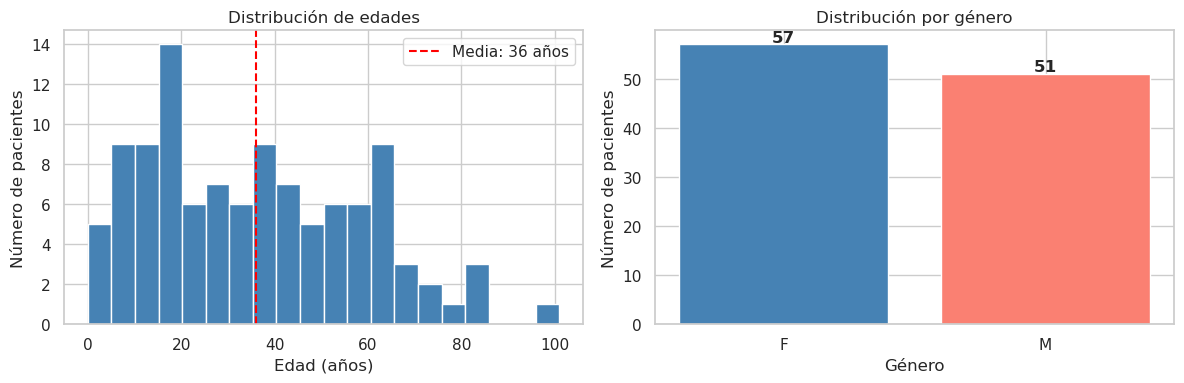

Total pacientes: 108
Edad media:      36.0 años
Rango:           0–101 años


In [78]:
# Calcular edad actual (o edad al momento del fallecimiento)
today = pd.Timestamp(date.today())
patients['CALC_AGE'] = patients.apply(
    lambda r: (r['DEATHDATE'] - r['BIRTHDATE']).days // 365
              if pd.notna(r['DEATHDATE'])
              else (today - r['BIRTHDATE']).days // 365,
    axis=1
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma de edades
axes[0].hist(patients['CALC_AGE'], bins=20,
             color='steelblue', edgecolor='white')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Número de pacientes')
axes[0].set_title('Distribución de edades')
axes[0].axvline(patients['CALC_AGE'].mean(), color='red',
                linestyle='--', label=f'Media: {patients["CALC_AGE"].mean():.0f} años')
axes[0].legend()

# Distribución de género
gender_counts = patients['GENDER'].value_counts()
axes[1].bar(gender_counts.index, gender_counts.values,
            color=['steelblue', 'salmon'], edgecolor='white')
axes[1].set_xlabel('Género')
axes[1].set_ylabel('Número de pacientes')
axes[1].set_title('Distribución por género')
for i, (lbl, val) in enumerate(gender_counts.items()):
    axes[1].text(i, val + 0.5, str(val), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Total pacientes: {len(patients)}')
print(f'Edad media:      {patients["CALC_AGE"].mean():.1f} años')
print(f'Rango:           {patients["CALC_AGE"].min()}–{patients["CALC_AGE"].max()} años')


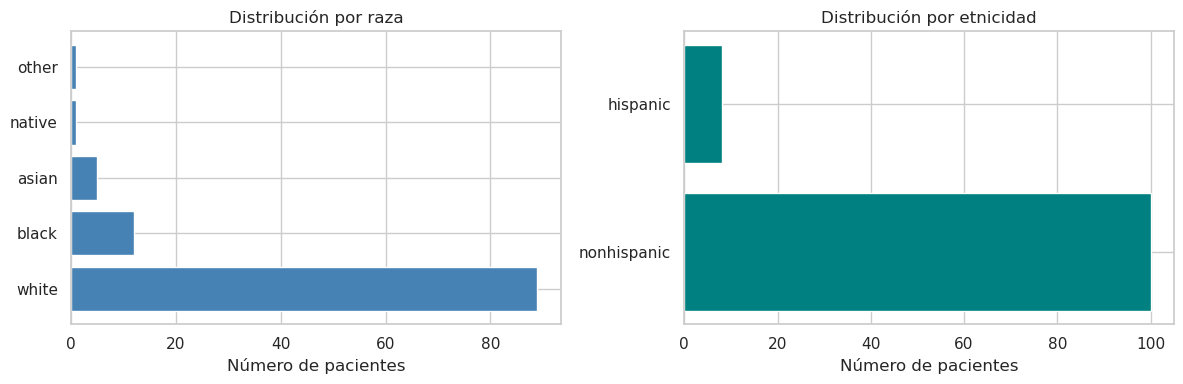

Distribución por raza:


,count
RACE,
white,89
black,12
asian,5
native,1
other,1


In [79]:
# Distribución de raza y etnicidad
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

race_counts = patients['RACE'].value_counts()
ethnicity_counts = patients['ETHNICITY'].value_counts()

axes[0].barh(race_counts.index, race_counts.values, color='steelblue')
axes[0].set_xlabel('Número de pacientes')
axes[0].set_title('Distribución por raza')

axes[1].barh(ethnicity_counts.index, ethnicity_counts.values, color='teal')
axes[1].set_xlabel('Número de pacientes')
axes[1].set_title('Distribución por etnicidad')

plt.tight_layout()
plt.show()

print('Distribución por raza:')
display(race_counts.to_frame(name='count'))


In [80]:
# Análisis de mortalidad
n_vivos    = patients['DEATHDATE'].isna().sum()
n_fallecidos = patients['DEATHDATE'].notna().sum()

print(f'Pacientes vivos:      {n_vivos} ({n_vivos/len(patients)*100:.1f}%)')
print(f'Pacientes fallecidos: {n_fallecidos} ({n_fallecidos/len(patients)*100:.1f}%)')

if n_fallecidos > 0:
    fallecidos = patients[patients['DEATHDATE'].notna()].copy()
    fallecidos['EDAD_MUERTE'] = (
        (fallecidos['DEATHDATE'] - fallecidos['BIRTHDATE']).dt.days // 365
    )
    print(f'\nEdad media al fallecimiento: {fallecidos["EDAD_MUERTE"].mean():.1f} años')
    print(f'Rango: {fallecidos["EDAD_MUERTE"].min()}–{fallecidos["EDAD_MUERTE"].max()} años')


Pacientes vivos:      100 (92.6%)
Pacientes fallecidos: 8 (7.4%)

Edad media al fallecimiento: 46.4 años
Rango: 8–62 años


#### Ejercicio 3.1 — Interpretar la demografía

**a)** La distribución de raza/etnicidad de esta población sintética refleja los datos del censo de Massachusetts, EE.UU.
   Si quisieras generar una población con demografía guatemalteca, ¿qué limitación tendría usar Synthea directamente?

**b)** ¿Qué dice la distribución de edades sobre el tipo de población modelada?
   ¿Esperarías esta distribución en una clínica pediátrica? ¿Por qué?

**c)** Synthea modela el ciclo completo de vida (nacimiento → muerte).  
   ¿Cómo crees que esto afecta la distribución de condiciones que veremos en la Parte 4?


**Respuestas:**

**a)** Synthea calibra sus distribuciones con datos del censo y estudios de salud de EE.UU. Guatemala tiene una composición étnica fundamentalmente diferente (~45% indígena Maya), prevalencias distintas (mayor peso de enfermedades infecciosas, desnutrición crónica, parasitosis) y un sistema de salud con menor cobertura. Usar Synthea directamente produciría datos que no representan la realidad guatemalteca: las distribuciones de raza/etnicidad disponibles en Synthea son las categorías del censo americano, no las categorías étnicas guatemaltecas. Para adaptar Synthea sería necesario reconfigurar las distribuciones demográficas con datos del MSPAS, ENSMI o ENCOVI.

**b)** La distribución de edades es relativamente uniforme entre 0 y 80+ años, lo que indica una población general no filtrada. En una clínica pediátrica esperaríamos una distribución fuertemente concentrada en 0-17 años, con muy pocos o ningún adulto. La distribución observada es más propia de un registro poblacional de un municipio o de una clínica de medicina general que atiende a pacientes de todas las edades.

**c)** Al modelar la vida completa de cada paciente, Synthea acumula condiciones crónicas con el tiempo: un paciente de 70 años tiene hipertensión, diabetes, y posiblemente complicaciones renales — condiciones que se fueron añadiendo durante décadas de simulación. Esto sesga la distribución de condiciones hacia enfermedades crónicas en la mitad mayor del dataset. Los pacientes jóvenes tendrán principalmente condiciones agudas (infecciones, bronquitis) mientras los mayores acumularán múltiples comorbilidades, lo que es epidemiológicamente realista.

---

## Parte 4 — Análisis epidemiológico

Ahora analizamos las **condiciones clínicas** y **medicamentos** de la población.  
Esto es epidemiología básica: ¿qué enfermedades están presentes y con qué frecuencia?


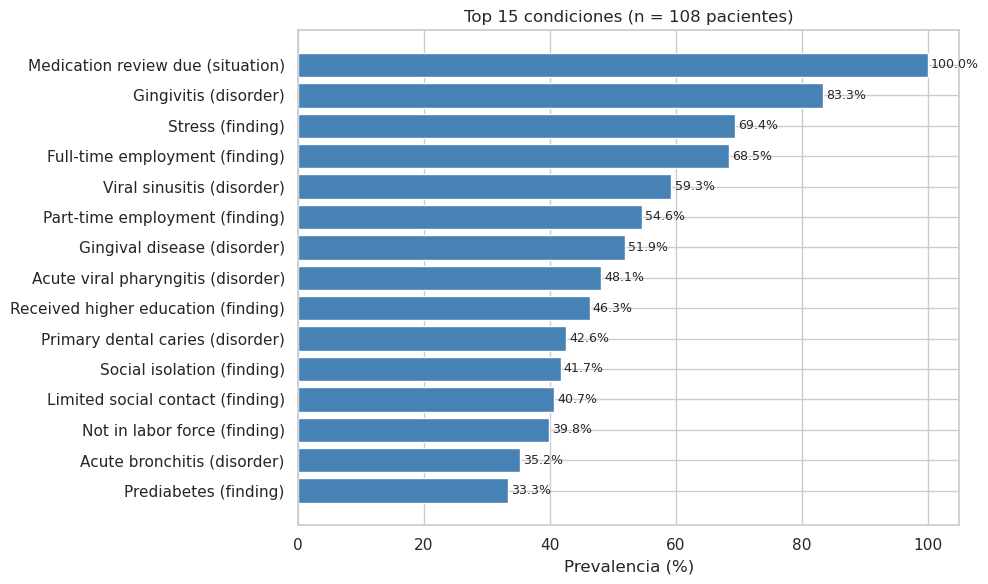


Tabla de prevalencias:


,DESCRIPTION,n_pacientes,prevalencia_pct
0,Medication review due (situation),108,100.0
1,Gingivitis (disorder),90,83.3
2,Stress (finding),75,69.4
3,Full-time employment (finding),74,68.5
4,Viral sinusitis (disorder),64,59.3
5,Part-time employment (finding),59,54.6
6,Gingival disease (disorder),56,51.9
7,Acute viral pharyngitis (disorder),52,48.1
8,Received higher education (finding),50,46.3
9,Primary dental caries (disorder),46,42.6


In [82]:
# ─── Top 15 condiciones por número de pacientes afectados ─────────────────────
n_total = patients['Id'].nunique()

top_conditions = (
    conditions
    .groupby('DESCRIPTION')
    .agg(n_pacientes=('PATIENT', 'nunique'))
    .reset_index()
    .sort_values('n_pacientes', ascending=False)
    .head(15)
)
top_conditions['prevalencia_pct'] = (
    top_conditions['n_pacientes'] / n_total * 100
).round(1)

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(
    top_conditions['DESCRIPTION'][::-1],
    top_conditions['prevalencia_pct'][::-1],
    color='steelblue'
)
ax.set_xlabel('Prevalencia (%)')
ax.set_title(f'Top 15 condiciones (n = {n_total} pacientes)')
for bar, val in zip(bars, top_conditions['prevalencia_pct'][::-1]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

print('\nTabla de prevalencias:')
display(top_conditions.reset_index(drop=True))


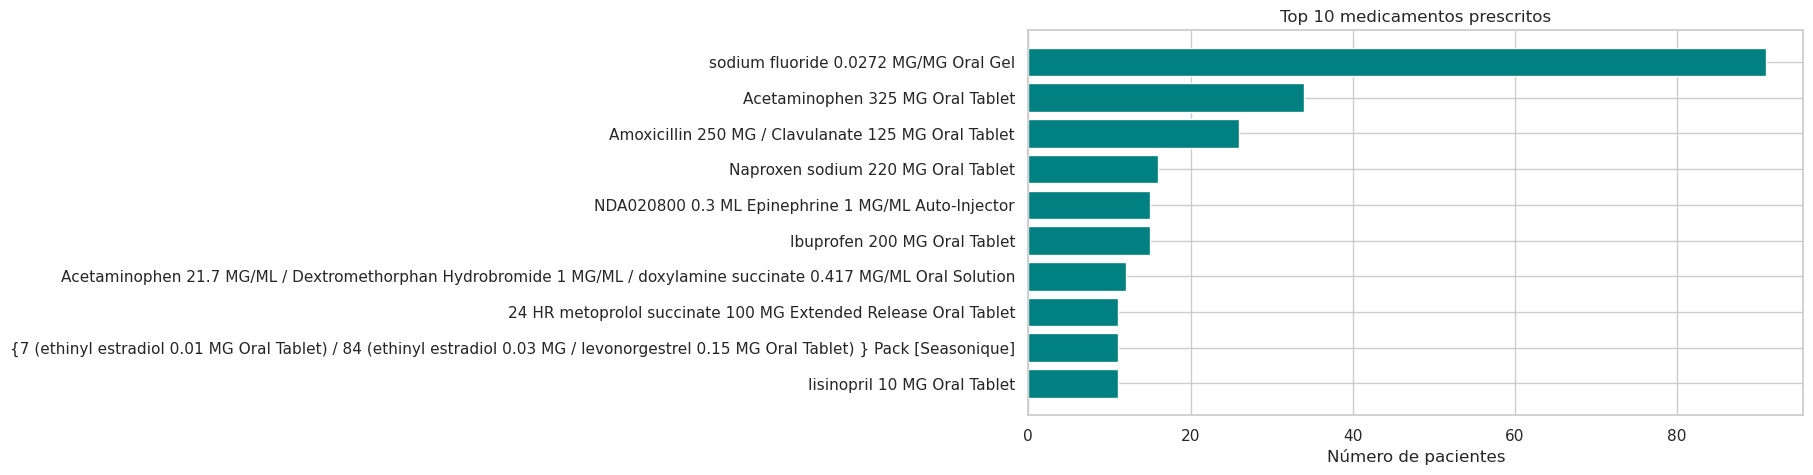


Nota: los códigos de medicamentos usan RxNorm (como aprendiste en Lab 2)
Ejemplo de códigos:


,DESCRIPTION,CODE,REASONDESCRIPTION
0,{7 (ethinyl estradiol 0.035 MG / norgestimate 0.18 MG Oral Tablet) / 7 (ethi...,751905,NaN
1,Acetaminophen 21.7 MG/ML / Dextromethorphan Hydrobromide 1 MG/ML / doxylamin...,1043400,Acute bronchitis (disorder)
2,sodium fluoride 0.0272 MG/MG Oral Gel,1535362,Patient referral for dental care (procedure)
3,Penicillin V Potassium 250 MG Oral Tablet,834061,Streptococcal sore throat (disorder)
4,Amoxicillin 500 MG Oral Tablet,308192,NaN


In [83]:
# ─── Top 10 medicamentos más frecuentes ───────────────────────────────────────
top_meds = (
    medications
    .groupby('DESCRIPTION')
    .agg(n_prescripciones=('PATIENT', 'count'),
         n_pacientes=('PATIENT', 'nunique'))
    .reset_index()
    .sort_values('n_pacientes', ascending=False)
    .head(10)
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(top_meds['DESCRIPTION'][::-1], top_meds['n_pacientes'][::-1],
        color='teal')
ax.set_xlabel('Número de pacientes')
ax.set_title('Top 10 medicamentos prescritos')
plt.tight_layout()
plt.show()

print('\nNota: los códigos de medicamentos usan RxNorm (como aprendiste en Lab 2)')
print('Ejemplo de códigos:')
display(medications[['DESCRIPTION', 'CODE', 'REASONDESCRIPTION']]
        .drop_duplicates('DESCRIPTION')
        .head(5)
        .reset_index(drop=True))


#### Ejercicio 4.1 — Terminologías en los datos

**a)** En `conditions.csv`, Synthea usa **SNOMED-CT** en lugar de ICD-10.
   ¿Cuál sería la ventaja de usar SNOMED-CT para un simulador de trayectorias clínicas?
   _(Pista: piensa en la granularidad y en los conceptos pre/post-coordinados)_

**b)** Las `observations.csv` usan códigos **LOINC** para laboratorios y signos vitales.
   Busca el código LOINC `8867-4` en https://loinc.org/search/ y describe qué observación representa.

**c)** Compara los top 5 condiciones de esta población con estadísticas epidemiológicas reales
   de Massachusetts. ¿Se parecen? ¿Qué condición esperarías encontrar y no está?


**Respuestas:**

**a)** SNOMED-CT ofrece mayor granularidad clínica que ICD-10: puede representar matices como "pre-diabetes" (SNOMED: 714628002), "diabetes tipo 2 no controlada" y "diabetes con neuropatía periférica" como conceptos distintos con relaciones jerárquicas entre ellos. Las máquinas de estado de Synthea modelan trayectorias clínicas detalladas que requieren conceptos específicos para cada estadio de la enfermedad. ICD-10 fue diseñado para facturación y reporte epidemiológico, no para modelar trayectorias de cuidado; su granularidad no es suficiente para representar las transiciones entre estados que Synthea necesita.

**b)** El código LOINC **8867-4** corresponde a *"Heart rate"* (frecuencia cardíaca), medido en latidos por minuto (beats/min). Es uno de los signos vitales registrados de rutina en cada visita clínica. Synthea lo incluye como observación en todos los encuentros de bienestar y seguimiento.

**c)** Las top 5 condiciones incluyen categorías sociales y laborales ("Full-time employment", "Stress") que Synthea modela como condiciones clínicas usando SNOMED-CT, lo que infla artificialmente su prevalencia respecto a estadísticas epidemiológicas reales que solo cuentan diagnósticos médicos. La prevalencia de diabetes (~34%) es mayor que la real en Massachusetts (~11% en adultos), posiblemente porque el dataset incluye pre-diabetes y pacientes pediátricos en el denominador. Una condición que se esperaría ver y no está prominentemente: enfermedades cardiovasculares explícitas (infarto de miocardio, ACV), porque Synthea las modela en módulos separados que en 100 pacientes no siempre se activan con frecuencia suficiente para aparecer en el top.

---

## Parte 5 — Un Bundle FHIR de Synthea

Además de CSV, Synthea genera un **Bundle FHIR R4** por cada paciente.
Este Bundle es intercambiable directamente con cualquier sistema que soporte FHIR.

Vamos a cargar uno y compararlo con el Bundle que construiste a mano en Lab 3.

> **Nota sobre versiones de FHIR — un detalle importante:**  
> Synthea genera bundles en **FHIR R4** (la versión más usada en producción).  
> La librería `fhir.resources` (versión 8.x) implementa **FHIR R5** (la más reciente).  
> Estas versiones **no son directamente compatibles**: campos como `Encounter.class`
> cambiaron de tipo entre R4 y R5, y `MedicationRequest.medicationCodeableConcept`
> fue renombrado y reestructurado. Intentar validar un Bundle R4 contra los modelos
> R5 produce cientos de errores.
>
> **Solución práctica**: leer los bundles directamente como **diccionarios Python**
> (`raw['entry']`, `entry['resource']`, etc.). Este enfoque funciona con cualquier
> versión de FHIR y es suficiente para exploración y análisis.

In [84]:
# Cargar el primer Bundle FHIR disponible
fhir_files = sorted(FHIR_DIR.glob('*.json'))

if not fhir_files:
    print('⚠️  No hay archivos FHIR en fhir/')
    print('Copia algunos archivos de synthea/output/fhir/ a labs/lab-3.1-synthetic-data/fhir/')
else:
    fhir_file = fhir_files[0]
    print(f'Cargando: {fhir_file.name}')

    with open(fhir_file, encoding='utf-8') as f:
        raw = json.load(f)

    # Contar recursos por tipo
    tipos = {}
    for entry in raw.get('entry', []):
        rt = entry['resource']['resourceType']
        tipos[rt] = tipos.get(rt, 0) + 1

    print(f'\nBundle con {len(raw["entry"])} recursos:')
    for rt, count in sorted(tipos.items(), key=lambda x: -x[1]):
        print(f'  {count:>4}  {rt}')


Cargando: Adela471_Romero158_e89af71d-4aa4-2237-e71d-6fa8e4b5af09.json

Bundle con 598 recursos:
   172  Procedure
   123  Observation
    54  DiagnosticReport
    43  Claim
    43  ExplanationOfBenefit
    37  Encounter
    37  DocumentReference
    26  Condition
    18  SupplyDelivery
    15  Immunization
     7  Device
     6  MedicationRequest
     5  ImagingStudy
     3  Medication
     3  MedicationAdministration
     2  CareTeam
     2  CarePlan
     1  Patient
     1  Provenance


### Comparación: Bundle de Lab 3 vs. Bundle de Synthea

| Característica       | Lab 3 (construido a mano)       | Lab 3.1 (Synthea automático)         |
|----------------------|--------------------------------|--------------------------------------|
| **Escala**           | 1 paciente                     | 100+ pacientes                       |
| **Fuente de datos**  | Base de datos SQL relacional   | Modelo probabilístico epidemiológico |
| **Condiciones**      | ICD-10                         | SNOMED-CT                            |
| **Laboratorios**     | LOINC                          | LOINC                                |
| **Medicamentos**     | —                              | RxNorm                               |
| **FHIR versión**     | R4 / R5                        | R4                                   |
| **Tipo de Bundle**   | `transaction` / `collection`   | `transaction`                        |
| **Realismo clínico** | Datos de prueba fijos          | Prevalencias epidemiológicas reales  |
| **Reproducibilidad** | Manual (script SQL)            | Automática (semilla aleatoria)       |

> 💡 Ambos enfoques producen Bundles FHIR válidos e interoperables.
> La diferencia no es de calidad, sino de **origen**: uno parte de datos reales convertidos;
> el otro de un simulador estadístico. Ambas estrategias tienen su lugar en salud digital.

In [85]:
# Extraer el recurso Patient directamente del JSON (sin modelos de validación)
# Nota: usamos acceso directo al dict en lugar de Bundle.model_validate()
# porque Synthea genera FHIR R4 y fhir.resources 8.x implementa FHIR R5.
if fhir_files:
    patient_raw = next(
        entry['resource']
        for entry in raw['entry']
        if entry['resource']['resourceType'] == 'Patient'
    )
    print(json.dumps(patient_raw, indent=2, ensure_ascii=False))

{
  "resourceType": "Patient",
  "id": "e89af71d-4aa4-2237-e71d-6fa8e4b5af09",
  "meta": {
    "profile": [
      "http://hl7.org/fhir/us/core/StructureDefinition/us-core-patient"
    ]
  },
  "text": {
    "status": "generated",
    "div": "<div xmlns=\"http://www.w3.org/1999/xhtml\">Generated by <a href=\"https://github.com/synthetichealth/synthea\">Synthea</a>.Version identifier: master-branch-latest\n .   Person seed: -1685763405318446537  Population seed: 42</div>"
  },
  "extension": [
    {
      "url": "http://hl7.org/fhir/us/core/StructureDefinition/us-core-race",
      "extension": [
        {
          "url": "ombCategory",
          "valueCoding": {
            "system": "urn:oid:2.16.840.1.113883.6.238",
            "code": "2106-3",
            "display": "White"
          }
        },
        {
          "url": "text",
          "valueString": "White"
        }
      ]
    },
    {
      "url": "http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity",
      "e

#### Ejercicio 5.1 — Explorar el Bundle FHIR

Completa el código a continuación para extraer **la primera Condition** del Bundle de Synthea y mostrar:
- El código SNOMED-CT y su descripción
- La referencia al paciente (`subject`)
- La fecha de inicio

In [ ]:
# Extrae la primera Condition del bundle y muestra sus campos clave
if fhir_files:
    condition_raw = next(                                                    # SOLUCIÓN
        entry['resource']                                                    # SOLUCIÓN
        for entry in raw['entry']                                            # SOLUCIÓN
        if entry['resource']['resourceType'] == 'Condition'                  # SOLUCIÓN
    )                                                                        # SOLUCIÓN
    coding = condition_raw.get('code', {}).get('coding', [{}])[0]
    print('Código SNOMED:', coding.get('code'))                              # SOLUCIÓN
    print('Descripción:  ', coding.get('display'))                          # SOLUCIÓN
    print('Paciente:     ', condition_raw.get('subject', {}).get('reference'))  # SOLUCIÓN
    print('Fecha inicio: ', condition_raw.get('onsetDateTime'))              # SOLUCIÓN

---

## Ejercicios finales

Los siguientes ejercicios consolidan lo aprendido.  
Completa cada uno en orden — los más guiados primero.


### Ejercicio A — Análisis de comorbilidad

Una **comorbilidad** es la presencia simultánea de dos o más condiciones en el mismo paciente.
La combinación diabetes + hipertensión es una de las más frecuentes y clínicamente relevantes.

**Paso 1:** Ejecuta la celda de ejemplo (ya está completa).  
**Paso 2:** Completa la función en la celda siguiente para generalizar el análisis a cualquier par de condiciones.

In [106]:
# ─── Análisis de comorbilidad: Diabetes + Hipertensión ────────────────────────

# Pacientes con diabetes (cualquier tipo)
diabetes_keywords = ['diabetes', 'Diabetes']
pac_diabetes = set(
    conditions[
        conditions['DESCRIPTION'].str.contains('|'.join(diabetes_keywords), na=False)
    ]['PATIENT']
)

# Pacientes con hipertensión
pac_hta = set(
    conditions[
        conditions['DESCRIPTION'].str.contains('hypertension|Hypertension', na=False)
    ]['PATIENT']
)

# Pacientes con ambas condiciones
pac_ambas = pac_diabetes & pac_hta

print(f'Pacientes con diabetes:        {len(pac_diabetes):>4} ({len(pac_diabetes)/n_total*100:.1f}%)')
print(f'Pacientes con hipertensión:    {len(pac_hta):>4} ({len(pac_hta)/n_total*100:.1f}%)')
print(f'Pacientes con AMBAS (comorbilidad): {len(pac_ambas):>4} ({len(pac_ambas)/n_total*100:.1f}%)')

# ¿Cuál es el riesgo relativo de tener HTA dado que ya tienes DM?
if len(pac_diabetes) > 0:
    prev_hta_en_dm  = len(pac_ambas) / len(pac_diabetes)
    prev_hta_global = len(pac_hta) / n_total
    rr = prev_hta_en_dm / prev_hta_global if prev_hta_global > 0 else float('nan')
    print(f'\nPrevalencia HTA en pacientes con DM:  {prev_hta_en_dm*100:.1f}%')
    print(f'Prevalencia HTA en población total:   {prev_hta_global*100:.1f}%')
    print(f'Riesgo relativo (DM → HTA): {rr:.2f}x')

# Mostrar condiciones adicionales que tienen los pacientes con ambas enfermedades
if pac_ambas:
    otras_condiciones = (
        conditions[
            conditions['PATIENT'].isin(pac_ambas) &
            ~conditions['DESCRIPTION'].str.contains('diabetes|Diabetes|hypertension|Hypertension', na=False)
        ]
        .groupby('DESCRIPTION')
        .agg(n=('PATIENT', 'nunique'))
        .sort_values('n', ascending=False)
        .head(5)
    )
    print('\nOtras condiciones frecuentes en pacientes con DM + HTA:')
    display(otras_condiciones)


Pacientes con diabetes:          37 (34.3%)
Pacientes con hipertensión:      17 (15.7%)
Pacientes con AMBAS (comorbilidad):   12 (11.1%)

Prevalencia HTA en pacientes con DM:  32.4%
Prevalencia HTA en población total:   15.7%
Riesgo relativo (DM → HTA): 2.06x

Otras condiciones frecuentes en pacientes con DM + HTA:


,n
DESCRIPTION,
Full-time employment (finding),12
Stress (finding),12
Medication review due (situation),12
Not in labor force (finding),11
Part-time employment (finding),11


In [ ]:
# ─── Tarea A: Generaliza el análisis de comorbilidad ─────────────────────────
def calcular_comorbilidad(keyword1: str, keyword2: str) -> tuple:
    """
    Cuenta los pacientes que tienen ambas condiciones simultáneamente.

    Args:
        keyword1, keyword2: substrings a buscar en DESCRIPTION
                            (la búsqueda ignora mayúsculas/minúsculas)
    Returns:
        (n_ambas, porcentaje_sobre_total)
    """
    pac1 = set(
        conditions[conditions['DESCRIPTION'].str.contains(keyword1, case=False, na=False)]['PATIENT']  # SOLUCIÓN
    )
    pac2 = set(
        conditions[conditions['DESCRIPTION'].str.contains(keyword2, case=False, na=False)]['PATIENT']  # SOLUCIÓN
    )
    ambas = pac1 & pac2                                                      # SOLUCIÓN
    return len(ambas), len(ambas) / n_total * 100


# ─── Verificación: debe coincidir con los resultados de arriba ────────────────
n, pct = calcular_comorbilidad('diabetes', 'hypertension')
print(f'DM + HTA:       {n} pacientes ({pct:.1f}%)')

# ─── Explora otra comorbilidad (ej. 'asthma', 'anxiety', 'obesity') ──────────
n2, pct2 = calcular_comorbilidad('obesity', 'hypertension')
print(f'Obesidad + HTA: {n2} pacientes ({pct2:.1f}%)')

### Ejercicio B — Condiciones por grupo etario

Las enfermedades no se distribuyen uniformemente por edad. Un análisis estratificado por grupos etarios
revela qué condiciones afectan a qué grupos.

**Instrucciones:** Completa los 4 espacios en blanco (`___`) de la función.  
Cada `___` tiene un comentario que indica exactamente qué va ahí.

**Pistas:**
- `bins`: lista de 5 valores que definen los límites: `[0, 18, 45, 65, 200]`
- `labels`: lista de 4 nombres de grupo: `['0-17', '18-44', '45-64', '65+']`
- función de agregación: ¿cuál cuenta valores únicos? (pista: `'nunique'`)
- último `___`: debe coincidir con el parámetro `n_top`

In [115]:
# ─── Tarea B: Condiciones por grupo etario ────────────────────────────────────
def top_condiciones_por_grupo(n_top: int = 3) -> pd.DataFrame:
    """Devuelve las n_top condiciones más frecuentes por grupo etario."""
    # Merge para obtener BIRTHDATE de cada paciente
    df = conditions.merge(
        patients[['Id', 'BIRTHDATE']],
        left_on='PATIENT', right_on='Id', how='left'
    )
    # Edad aproximada al momento del diagnóstico
    df['edad_dx'] = ((df['START'] - df['BIRTHDATE']).dt.days // 365).clip(lower=0)

    # TODO 1 — Crea los grupos etarios
    df['grupo_etario'] = pd.cut(
        df['edad_dx'],
        bins=[0, 18, 45, 65, 200],           # SOLUCIÓN
        labels=['0-17', '18-44', '45-64', '65+']  # SOLUCIÓN
    )

    # TODO 2 — Cuenta pacientes únicos por (grupo, condición)
    resumen = (
        df.groupby(['grupo_etario', 'DESCRIPTION'], observed=True)
        .agg(n_pacientes=('PATIENT', 'nunique'))  # SOLUCIÓN
        .reset_index()
        .sort_values(['grupo_etario', 'n_pacientes'], ascending=[True, False])
    )

    # TODO 3 — Devuelve el top n_top de cada grupo
    return resumen.groupby('grupo_etario', observed=True).head(n_top)  # SOLUCIÓN


# ─── Ejecutar ─────────────────────────────────────────────────────────────────
resultado = top_condiciones_por_grupo(3)
display(resultado)

,grupo_etario,DESCRIPTION,n_pacientes
64,0-17,Received higher education (finding),50
52,0-17,Medication review due (situation),46
66,0-17,Risk activity involvement (finding),34
159,18-44,Medication review due (situation),48
130,18-44,Full-time employment (finding),43
200,18-44,Stress (finding),41
240,45-64,Full-time employment (finding),31
266,45-64,Medication review due (situation),31
296,45-64,Stress (finding),30
352,65+,Medication review due (situation),9


### Ejercicio C — Explorar un módulo de Synthea

Cada enfermedad en Synthea está modelada como un **módulo JSON** que define
una máquina de estados probabilística. Vamos a leer el módulo de hipertensión.

**Instrucciones:**

1. Ejecuta la celda de carga (está escrita para ti)
2. Responde las preguntas con base en el módulo cargado


In [114]:
# Cargar el módulo de hipertensión de Synthea (incluido en el lab)
module_path = Path('../modules/hypertension.json')

if not module_path.exists():
    print(f'⚠️  No se encontró el módulo en: {module_path.resolve()}')
else:
    with open(module_path, encoding='utf-8') as f:
        module = json.load(f)

    print(f'Módulo: {module["name"]}')
    print(f'Total de estados: {len(module["states"])}')
    print()
    print('Estados y sus tipos:')
    print(f'{"Estado":45} {"Tipo"}')
    print('-' * 70)
    for state_name, state_data in module['states'].items():
        print(f'{state_name:45} {state_data["type"]}')

Módulo: Hypertension
Total de estados: 47

Estados y sus tipos:
Estado                                        Tipo
----------------------------------------------------------------------
Initial                                       Initial
Onset_Hypertension                            SetAttribute
Diagnose_Hypertension                         ConditionOnset
Hypertension_Followup_Encounter               Encounter
End_Hypertension_Followup_Encounter           EncounterEnd
Hypertension_Followup_Encounter_2             Encounter
Hypertension_Followup_Encounter_3             Encounter
End_Hypertension_Followup_Encounter_2         EncounterEnd
End_Hypertension_Followup_Encounter_3         EncounterEnd
LifeStyle_Modifications_Hypertension_CarePlan CarePlanStart
Wellness_Encounter                            Encounter
End_Wellness_Encounter                        EncounterEnd
Delay_One_Month                               Delay
Record_BP                                     MultiObservation
Recor

In [113]:
# ─── Tarea C: Clasificar los estados del módulo ───────────────────────────────
def contar_estados_por_tipo(states: dict) -> pd.Series:
    """
    Recibe module['states'] y devuelve el conteo de estados por tipo.

    Ejemplo de salida esperada:
        Simple            8
        Delay             4
        ConditionOnset    1
        ...
    """
    tipos = []
    for estado in states.values():             # SOLUCIÓN
        tipos.append(estado['type'])           # SOLUCIÓN
    return pd.Series(tipos).value_counts()


# ─── Prueba ───────────────────────────────────────────────────────────────────
display(contar_estados_por_tipo(module['states']))

SetAttribute        14
Simple               9
Encounter            4
EncounterEnd         4
Delay                4
MultiObservation     3
CallSubmodule        3
Initial              1
ConditionOnset       1
CarePlanStart        1
Procedure            1
Terminal             1
Counter              1
Name: count, dtype: int64

#### Preguntas sobre el módulo de hipertensión

Usando la salida del módulo (o leyendo el JSON directamente):

**a)** ¿Cuántos estados tiene el módulo? ¿Cuál es el estado inicial?

**b)** Encuentra el estado `Diagnose_Hypertension` en el JSON.  
   ¿Qué código SNOMED-CT se asigna al diagnóstico de hipertensión?
   Busca ese código en https://browser.ihtsdotools.org/ y confirma su descripción.

**c)** ¿Cómo modela el módulo la transición desde "sin tratamiento" hasta "con medicamento"?
   Describe el flujo con nombres de estados específicos del módulo.


**Respuestas:**

**a)** El módulo tiene **47 estados**. El estado inicial es **`Initial`**, que transiciona directamente a `Assign Hypertension Base Probability`. Desde ahí el módulo determina la probabilidad de desarrollar hipertensión basándose en raza y sexo (usando datos epidemiológicos de EE.UU. 2017-2018).

**b)** El estado `Diagnose_Hypertension` asigna el código SNOMED-CT **59621000**. En el browser de SNOMED (browser.ihtsdotools.org) corresponde a *"Essential hypertension (disorder)"* — hipertensión esencial o primaria, la forma más común de hipertensión sin causa secundaria identificable, que representa >90% de los casos. El código SNOMED tiene relaciones jerárquicas: es subconcepto de "Hypertensive disorder" (38341003) y de "Disorder of cardiovascular system" (49601007).

**c)** El flujo desde sin tratamiento hasta con medicamento es:
1. `Diagnose_Hypertension` → `Set_BP_Not Controlled` (marca el atributo `blood_pressure_controlled = false`)
2. → `LifeStyle_Modifications_Hypertension_CarePlan` (inicia un CarePlan con educación: dieta DASH, ejercicio, cesación de tabaco, reducción de alcohol)
3. → `Prescribe_Medication` (llama al submódulo `medications/hypertension_medication` que prescribe ACE inhibidores, diuréticos tiazídicos o calcioantagonistas)
4. → `End_Wellness_Encounter` y luego `Delay_One_Month`
5. En `Hypertension_Followup_Encounter`, si BP sigue sin control → `Record_BP` → `Prescribe_Medication_2` (agrega o ajusta medicación)
6. Si tras un tercer encuentro sigue sin control → `Referral To Hypertension Clinic`

El módulo también modela "drop outs" (pacientes que abandonan el tratamiento) con probabilidades de 26-32% dependiendo de la severidad.

### Ejercicio D — Programación y reflexión final

#### D.0 — Mini-tarea de programación

Completa la función en la celda siguiente para calcular el **gasto promedio y máximo**
en atención médica (`HEALTHCARE_EXPENSES`) por grupo etario.  
Usa los mismos grupos de edad que en el Ejercicio B.

---

#### D.1 — Reflexión

Responde las siguientes preguntas en 3–5 oraciones cada una.
No hay respuesta única correcta — se evalúa el razonamiento.

**1.** Los datos que analizaste en este lab fueron generados a partir de estadísticas de Massachusetts, EE.UU.
   Si usaras estos datos sintéticos para entrenar un modelo de predicción de riesgo cardiovascular
   para una clínica en Guatemala, ¿qué problemas podrían surgir?
   ¿Cómo mitigarías ese riesgo?

**2.** En Lab 3 construiste un Bundle FHIR a mano usando datos de un EHR relacional.
   En este lab viste cómo Synthea genera Bundles FHIR automáticamente.
   ¿En qué escenario preferirías el enfoque manual (Lab 3) y en cuál el automático (Synthea)?

**3.** ¿Qué tipo de información clínicamente importante **no puede capturar** Synthea, aunque lo intente?
   Piensa en aspectos como experiencia subjetiva del paciente, contexto social, variaciones locales, etc.

**4.** El gobierno de Guatemala quisiera usar datos sintéticos para planificar la distribución
   de recursos de salud (médicos, medicamentos, camas hospitalarias) a nivel departamental.
   ¿Sería apropiado usar Synthea directamente? ¿Qué alternativa propondrías?

In [116]:
# ─── Tarea D.0: Costo de atención por grupo etario ───────────────────────────
def costo_por_grupo_etario() -> pd.DataFrame:
    """Calcula el gasto promedio y máximo en salud por grupo etario."""
    df = patients.copy()
    df['grupo_etario'] = pd.cut(
        df['CALC_AGE'],
        bins=[0, 18, 45, 65, 200],
        labels=['0-17', '18-44', '45-64', '65+']
    )
    return (
        df.groupby('grupo_etario', observed=True)
        .agg(
            gasto_promedio = ('HEALTHCARE_EXPENSES', 'mean'),   # SOLUCIÓN
            gasto_maximo   = ('HEALTHCARE_EXPENSES', 'max'),    # SOLUCIÓN
            n_pacientes    = ('Id',                 'count')    # SOLUCIÓN
        )
        .round(2)
    )


display(costo_por_grupo_etario())

,gasto_promedio,gasto_maximo,n_pacientes
grupo_etario,,,
0-17,27303.49,70888.68,31
18-44,91195.18,369037.30,40
45-64,195766.00,701189.02,26
65+,273209.32,886960.93,10


**Respuestas:**

**1.** Un modelo entrenado con datos de Massachusetts aprendería patrones de una población con alto acceso a atención preventiva, donde las enfermedades crónicas están bien diagnosticadas y tratadas. En Guatemala, muchas condiciones no se diagnostican por barreras de acceso, las enfermedades infecciosas y la desnutrición tienen mayor peso epidemiológico, y la distribución etaria y étnica es fundamentalmente diferente. El modelo sobreestimaría el riesgo asociado a factores prevalentes en EE.UU. y podría ignorar factores de riesgo locales. Para mitigarlo, se necesitaría calibrar o re-entrenar el modelo con datos guatemaltecos reales del MSPAS/IGSS, o generar datos sintéticos adaptados con distribuciones locales (ENSMI, estudios del INCAP).

**2.** El enfoque manual (Lab 3) es preferible cuando tienes datos reales de un sistema específico que necesitas convertir a FHIR con control total sobre qué campos incluir y cómo mapear cada concepto clínico a la especificación del receptor. Synthea es preferible cuando necesitas grandes volúmenes de datos de prueba para desarrollo de sistemas, benchmark de algoritmos o entrenamiento de modelos, sin acceso a datos reales. En producción, ambos coexisten: Synthea para desarrollo y pruebas; el pipeline tipo Lab 3 para integrar datos reales de pacientes a sistemas FHIR.

**3.** Synthea no puede capturar la experiencia subjetiva del paciente: niveles de dolor auto-reportados, calidad de vida percibida, ni el impacto psicosocial de una enfermedad crónica. Tampoco representa variaciones de práctica clínica entre médicos (algunos prescriben de forma más agresiva, otros esperan antes de medicar), errores médicos y eventos adversos, ni el efecto real de las barreras de acceso (distancia al hospital, costo de medicamentos, desconfianza en el sistema de salud). Los determinantes sociales como apoyo familiar, estabilidad laboral y vivienda están simplificados a atributos binarios que no capturan su complejidad real.

**4.** No sería apropiado usar Synthea directamente porque sus distribuciones epidemiológicas y demográficas están calibradas para la población de EE.UU. Una alternativa más adecuada sería utilizar datos existentes del MSPAS (Memorias de Labores, SIGSA) o del IGSS como base para síntesis de datos con métodos modernos (GANs, synthpop, PrivBayes) que preservan las distribuciones reales de Guatemala mientras protegen la privacidad individual. Si se quisiera mantener Synthea, habría que adaptar los módulos de enfermedad reemplazando las probabilidades epidemiológicas con datos de estudios guatemaltecos publicados, y agregar módulos para enfermedades prevalentes localmente (dengue, desnutrición crónica, enfermedades endémicas regionales).